# Face Mask Detection Using Computer Vision and Machine Learning

This project aims to build a machine learning model that can detect whether a person is wearing a face mask or not. We'll use various computer vision techniques to extract features from facial images and train different classifiers to compare their performance.

## Project Overview
1. Extract meaningful features from facial images
2. Train multiple classifiers
3. Compare model performance
4. Determine the best approach for face mask detection

## Libraries and Setup
We'll use the following libraries:
- scikit-image for image processing and feature extraction
- scikit-learn for machine learning models and evaluation
- pandas/numpy for data manipulation
- matplotlib/seaborn for visualization

In [18]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from skimage import io, color, feature
from skimage.feature import hog, local_binary_pattern
from skimage.transform import resize
from skimage.color import rgb2gray
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.decomposition import PCA

## Dataset Setup
We'll work with a dataset containing two classes of images:
1. People wearing face masks
2. People without face masks

In [19]:
base_path = r"C:\Users\nisha\OneDrive\Desktop\Datasets\dataset"
with_mask_path = os.path.join(base_path, 'with_mask')
without_mask_path = os.path.join(base_path, 'without_mask')

Sample images with masks:


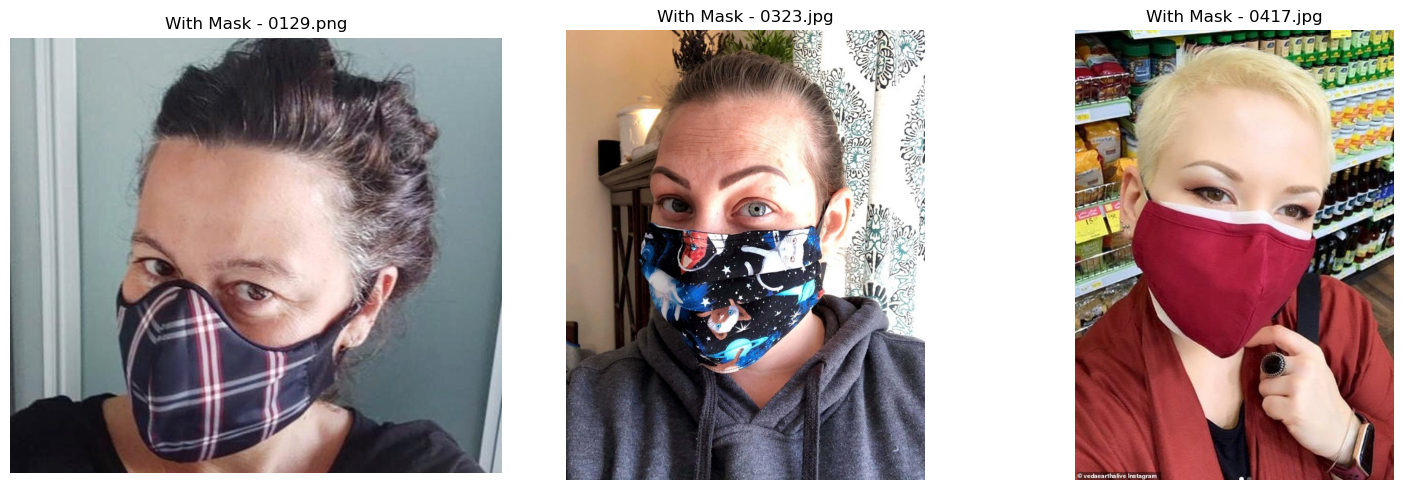


Sample images without masks:


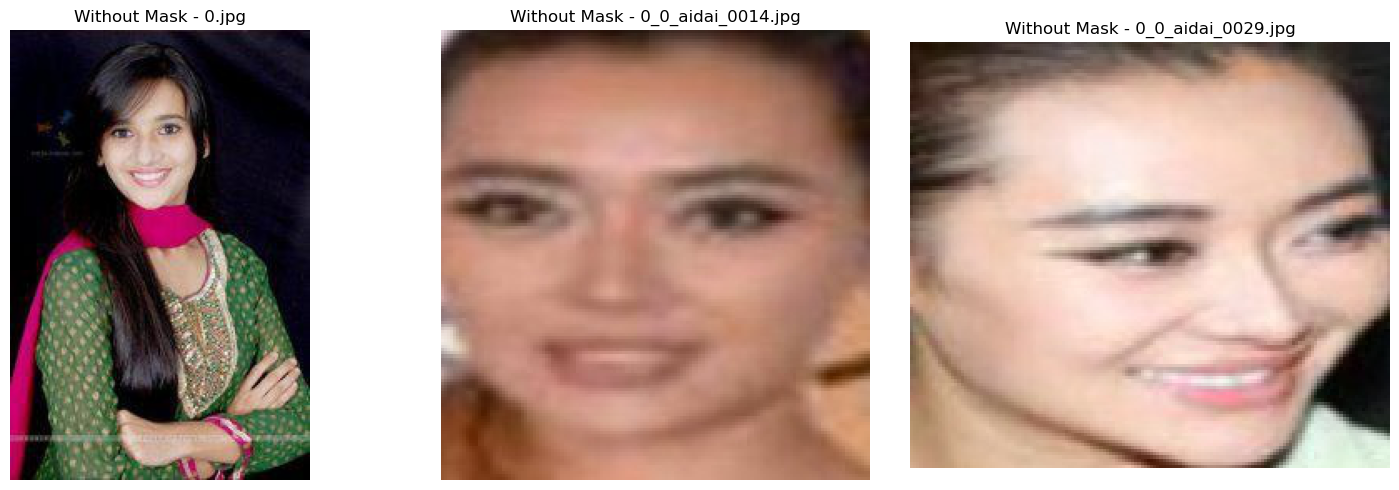

In [20]:
def show_imgs(path, count=3, header=""):
    
    img_files = os.listdir(path)[:count]
    
    plt.figure(figsize=(15, 5))
    for idx, fname in enumerate(img_files):
        full_path = os.path.join(path, fname)
        img = io.imread(full_path)
        
        plt.subplot(1, count, idx+1)
        plt.imshow(img)
        plt.title(f"{header} - {fname}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

print("Sample images with masks:")
show_imgs(with_mask_path, header="With Mask")

print("\nSample images without masks:")
show_imgs(without_mask_path, header="Without Mask")

## Feature Extraction
To train our machine learning models, we need to extract meaningful features from the images. We'll use multiple feature extraction techniques to capture different aspects of the images:

1. **HOG (Histogram of Oriented Gradients)**: Captures edge structures and shapes
2. **LBP (Local Binary Patterns)**: Captures local texture patterns
3. **Color Histograms**: Captures color distribution information
4. **Haralick Texture Features**: Captures complex texture information

These complementary features will help our model differentiate between masked and unmasked faces better than any single feature type alone.

In [21]:
def hog_extract(image, image_size=(128, 128)):
    
    resized = resize(image, image_size)
    if len(resized.shape) > 2:
        gray = rgb2gray(resized)
    else:
        gray = resized
    
    hog_features = hog(gray, orientations=9, pixels_per_cell=(8, 8),
                     cells_per_block=(2, 2), visualize=False)
    
    return hog_features

def lbp_extract(image, image_size=(128, 128)):
    
    resized = resize(image, image_size)
    
    if len(resized.shape) > 2:
        gray = rgb2gray(resized)
    else:
        gray = resized
    
    lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 10), density=True)
    
    return hist

def colhist_extract(image, image_size=(128, 128), bins=32):
    
    resized = resize(image, image_size)
    
    # For grayscale images, compute single histogram
    if len(resized.shape) <= 2:
        hist, _ = np.histogram(resized, bins=bins, range=(0, 1), density=True)
        return hist
    
    # For color images compute histogram for each channel
    hist_r, _ = np.histogram(resized[:,:,0], bins=bins, range=(0, 1), density=True)
    hist_g, _ = np.histogram(resized[:,:,1], bins=bins, range=(0, 1), density=True)
    hist_b, _ = np.histogram(resized[:,:,2], bins=bins, range=(0, 1), density=True)
    
    hist = np.concatenate([hist_r, hist_g, hist_b])
    
    return hist

def haralick_extract(image, image_size=(128, 128)):
    
    resized = resize(image, image_size)
    
    if len(resized.shape) > 2:
        gray = rgb2gray(resized)
    else:
        gray = resized
    
    # Convert float values to uint8
    gray_uint8 = (gray * 255).astype(np.uint8)
    

    haralick = feature.graycomatrix(gray_uint8, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4])
    contrast = feature.graycoprops(haralick, 'contrast')
    dissimilarity = feature.graycoprops(haralick, 'dissimilarity')
    homogeneity = feature.graycoprops(haralick, 'homogeneity')
    energy = feature.graycoprops(haralick, 'energy')
    correlation = feature.graycoprops(haralick, 'correlation')
    
    features = np.concatenate([contrast.ravel(), dissimilarity.ravel(), 
                             homogeneity.ravel(), energy.ravel(), 
                             correlation.ravel()])
    
    return features

def extract_all(path):
    try:
        img = io.imread(path)
        
        # Last RGBA check
        if len(img.shape) > 2 and img.shape[2] == 4:
            print(f"Skipping RGBA: {path}")
            return None
        
        hog = hog_extract(img)
        lbp = lbp_extract(img)
        hist = colhist_extract(img)
        haralick = haralick_extract(img)
        
        return np.concatenate([hog, lbp, hist, haralick])
        # return np.concatenate([hist, haralick])
        
    except Exception as e:
        print(f"Failed on {path}: {e}")
        return None

In [22]:
def load_and_extract(folder, label, max_count=None):
    
    feats = []
    lbls = []
    files = os.listdir(folder)
    
    # Cap samples if needed
    if max_count:
        files = files[:max_count]
    
    total = len(files)
    print(f"Processing {total} images from {os.path.basename(folder)}...")
    
    for i, f in enumerate(files):
        if i % 20 == 0:  # Show progress occasionally
            print(f"On image {i+1}/{total}...")
            
        img_path = os.path.join(folder, f)
        feat = extract_all(img_path)
        
        if feat is not None:
            feats.append(feat)
            lbls.append(label)
    
    return feats, lbls

def load(folder, max_count=None):
    """Grabs image paths, filters out RGBA"""
    files = os.listdir(folder)
    good_paths = []
    rgba_skipped = 0
    
    # Limit if needed
    if max_count:
        files = files[:max_count]
    
    total = len(files)
    print(f"Loading {total} images from {os.path.basename(folder)}...")
    
    for i, f in enumerate(files):
        if i % 20 == 0:
            print(f"Loading {i+1}/{total}...")
        
        path = os.path.join(folder, f)
        
        # Skip RGBA images
        try:
            img = io.imread(path)
            if len(img.shape) > 2 and img.shape[2] == 4:
                rgba_skipped += 1
                continue
            
            good_paths.append(path)
        except Exception as e:
            print(f"Error with {path}: {e}")
            continue
    
    print(f"Got {len(good_paths)} images. Skipped {rgba_skipped} RGBA ones.")
    return good_paths

def extract(paths, label):
    """Gets features from image paths with labels"""
    feats = []
    lbls = []
    
    total = len(paths)
    for i, path in enumerate(paths):
        if i % 20 == 0:
            print(f"Extracting {i+1}/{total}...")
            
        feat = extract_all(path)
        
        if feat is not None:
            feats.append(feat)
            lbls.append(label)
    
    return feats, lbls

In [23]:
mask_imgs = load(with_mask_path)  # Load everything by default
no_mask_imgs = load(without_mask_path)
print(f"Got {len(mask_imgs)} with-mask images")
print(f"Got {len(no_mask_imgs)} without-mask images")

print("\nExtracting features (grab a coffee, this'll take a while)...")
mask_feats, mask_lbls = extract(mask_imgs, 1)
no_mask_feats, no_mask_lbls = extract(no_mask_imgs, 0)

X = np.array(mask_feats + no_mask_feats)
y = np.array(mask_lbls + no_mask_lbls)

print(f"\nProcessed {len(X)} total samples")
print(f"Mask samples: {np.sum(y == 1)}")
print(f"No mask samples: {np.sum(y == 0)}")
print(f"Feature size: {X.shape[1]}")

Loading 2165 images from with_mask...
Loading 1/2165...
Loading 21/2165...
Loading 41/2165...
Loading 61/2165...
Loading 81/2165...
Loading 101/2165...
Loading 121/2165...
Loading 141/2165...
Loading 161/2165...
Loading 181/2165...
Loading 201/2165...
Loading 221/2165...
Loading 241/2165...
Loading 261/2165...
Loading 281/2165...
Loading 301/2165...
Loading 321/2165...
Loading 341/2165...
Loading 361/2165...
Loading 381/2165...
Loading 401/2165...
Loading 421/2165...
Loading 441/2165...
Loading 461/2165...
Loading 481/2165...
Loading 501/2165...
Loading 521/2165...
Loading 541/2165...
Loading 561/2165...
Loading 581/2165...
Loading 601/2165...
Loading 621/2165...
Loading 641/2165...
Loading 661/2165...
Loading 681/2165...
Loading 701/2165...
Loading 721/2165...
Loading 741/2165...
Loading 761/2165...
Loading 781/2165...
Loading 801/2165...
Loading 821/2165...
Loading 841/2165...
Loading 861/2165...
Loading 881/2165...
Loading 901/2165...
Loading 921/2165...
Loading 941/2165...
Loading 

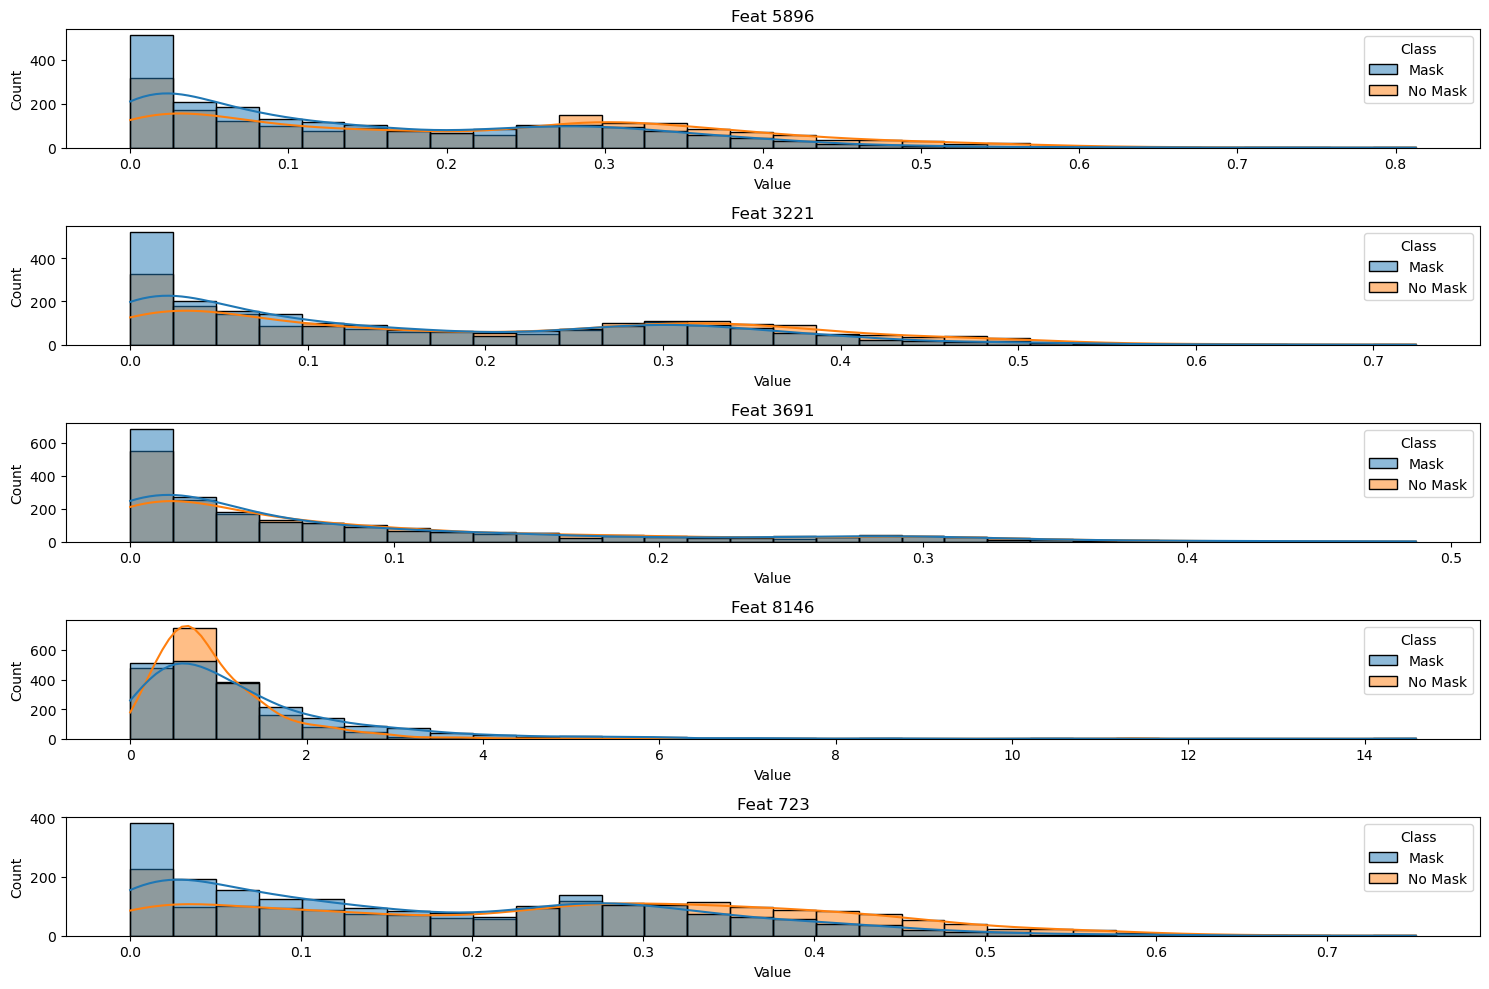

In [24]:
def plot_feature_dists(X, y, n_feats=5):

   # Picking some random features
   feat_idx = np.random.choice(X.shape[1], size=n_feats, replace=False)
   
   plt.figure(figsize=(15, 10))
   for i, idx in enumerate(feat_idx):
       plt.subplot(n_feats, 1, i+1)
       sns.histplot(data=pd.DataFrame({
           'Value': X[:, idx],
           'Class': ['Mask' if l == 1 else 'No Mask' for l in y]
       }), x='Value', hue='Class', kde=True, bins=30)
       plt.title(f'Feat {idx}')
   
   plt.tight_layout()
   plt.show()

plot_feature_dists(X, y)

## Dimensionality Reduction with PCA
With 8225 features, we risk overfitting our models. Principal Component Analysis (PCA) will help us:
1. Reduce dimensionality to avoid the curse of dimensionality
2. Remove redundant information
3. Speed up model training
4. Potentially improve generalization

We'll standardize the features first (important for PCA) and then reduce to 50 components:

Kept 33.44% of variance with 50 components


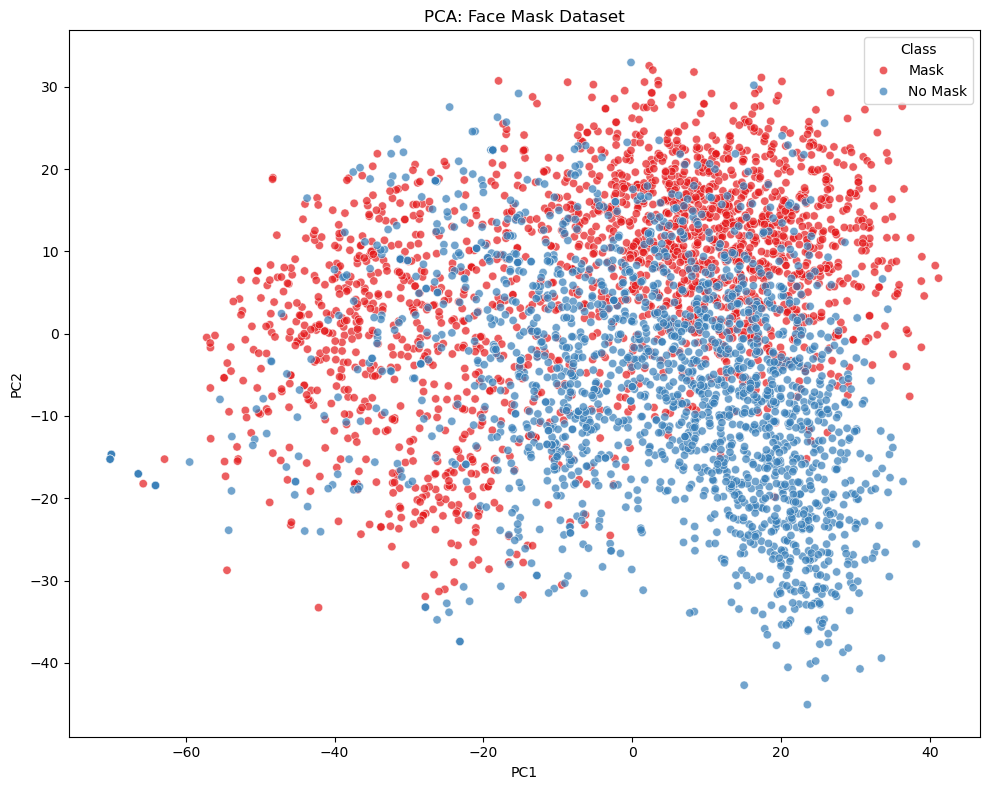

In [35]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=50)
X_pca = pca.fit_transform(X_scaled)

# How much info did we keep?
explained_var = np.sum(pca.explained_variance_ratio_) * 100
print(f"Kept {explained_var:.2f}% of variance with 50 components")

pca_viz = PCA(n_components=2)
X_2d = pca_viz.fit_transform(X_scaled)

df = pd.DataFrame(X_2d, columns=['PC1', 'PC2'])
df['Class'] = ['Mask' if l == 1 else 'No Mask' for l in y]

# Plot it
plt.figure(figsize=(10, 8))
sns.scatterplot(data=df, x='PC1', y='PC2', hue='Class', palette='Set1', alpha=0.7)
plt.title('PCA: Face Mask Dataset')
plt.tight_layout()
plt.show()

In [36]:
# Spilt
X_train, X_test, y_train, y_test = train_test_split(
    X_pca, y, test_size=0.3, random_state=42, stratify=y
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Testing set size: {X_test.shape[0]}")

Training set size: 2788
Testing set size: 1196


In [37]:
# SVM
svm = SVC(kernel='rbf', probability=True, random_state=42)
svm.fit(X_train, y_train)

svm_preds = svm.predict(X_test)
svm_probs = svm.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, svm_preds)
report = classification_report(y_test, svm_preds, target_names=['No Mask', 'Mask'])

print(f"SVM Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(report)

SVM Accuracy: 0.9181

Classification Report:
              precision    recall  f1-score   support

     No Mask       0.93      0.90      0.91       579
        Mask       0.91      0.94      0.92       617

    accuracy                           0.92      1196
   macro avg       0.92      0.92      0.92      1196
weighted avg       0.92      0.92      0.92      1196



In [28]:
# Neural Network

nn = MLPClassifier(
    hidden_layer_sizes=(100, 50),
    activation='relu',
    solver='adam',
    alpha=0.0001,
    batch_size='auto',
    learning_rate='adaptive',
    max_iter=500,
    random_state=42
)

nn.fit(X_train, y_train)

nn_preds = nn.predict(X_test)
nn_probs = nn.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, nn_preds)
report = classification_report(y_test, nn_preds, target_names=['No Mask', 'Mask'])

print(f"NN Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(report)

NN Accuracy: 0.9122

Classification Report:
              precision    recall  f1-score   support

     No Mask       0.90      0.92      0.91       579
        Mask       0.92      0.91      0.91       617

    accuracy                           0.91      1196
   macro avg       0.91      0.91      0.91      1196
weighted avg       0.91      0.91      0.91      1196



In [29]:
# Random Forest

rf = RandomForestClassifier(
    n_estimators=100, 
    max_depth=None,
    min_samples_split=2,
    random_state=42
)

rf.fit(X_train, y_train)

rf_preds = rf.predict(X_test)
rf_probs = rf.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, rf_preds)
report = classification_report(y_test, rf_preds, target_names=['No Mask', 'Mask'])

print(f"RF Accuracy: {acc:.4f}")
print("\nClassification Report:")
print(report)

RF Accuracy: 0.9022

Classification Report:
              precision    recall  f1-score   support

     No Mask       0.93      0.87      0.90       579
        Mask       0.88      0.94      0.91       617

    accuracy                           0.90      1196
   macro avg       0.90      0.90      0.90      1196
weighted avg       0.90      0.90      0.90      1196



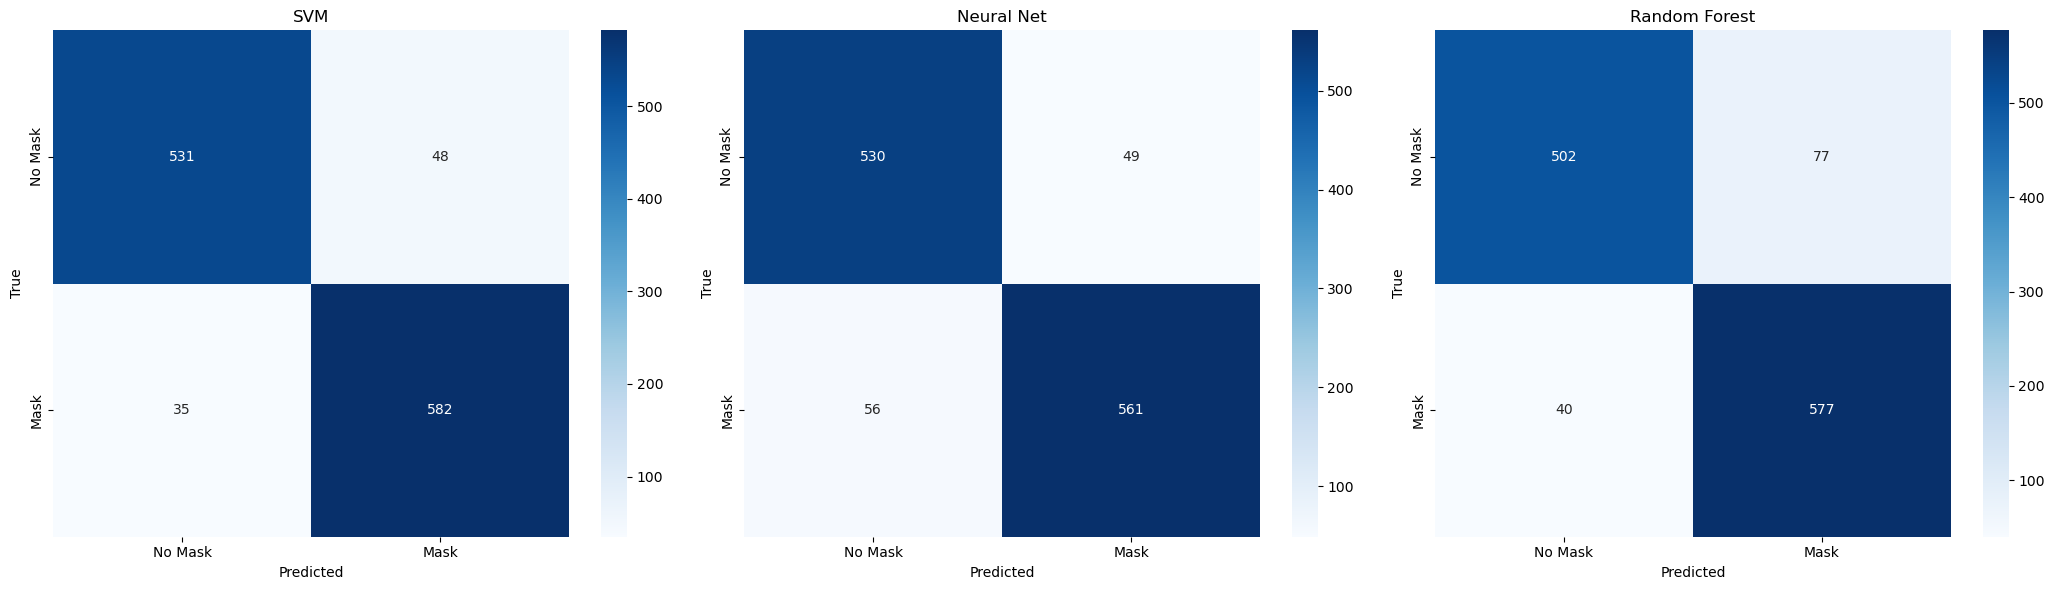

In [30]:
# Confusion matrices

fig, axes = plt.subplots(1, 3, figsize=(21, 6))

# SVM matrix
cm1 = confusion_matrix(y_test, svm_preds)
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Mask', 'Mask'],
            yticklabels=['No Mask', 'Mask'], ax=axes[0])
axes[0].set_title('SVM')
axes[0].set_ylabel('True')
axes[0].set_xlabel('Predicted')

# NN matrix
cm2 = confusion_matrix(y_test, nn_preds)
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Mask', 'Mask'],
            yticklabels=['No Mask', 'Mask'], ax=axes[1])
axes[1].set_title('Neural Net')
axes[1].set_ylabel('True')
axes[1].set_xlabel('Predicted')

# RF matrix
cm3 = confusion_matrix(y_test, rf_preds)
sns.heatmap(cm3, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Mask', 'Mask'],
            yticklabels=['No Mask', 'Mask'], ax=axes[2])
axes[2].set_title('Random Forest')
axes[2].set_ylabel('True')
axes[2].set_xlabel('Predicted')

plt.tight_layout()
plt.show()


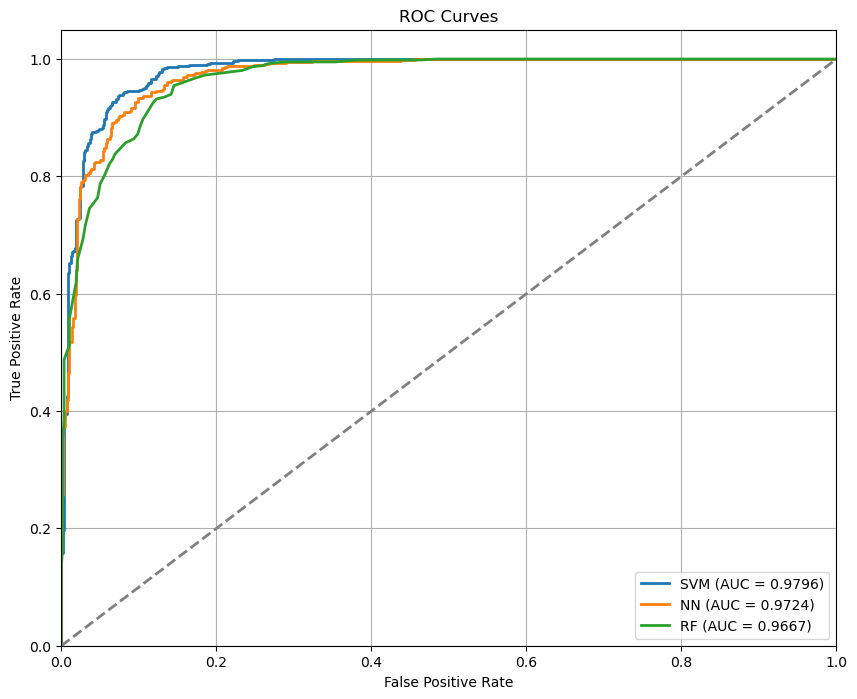

In [31]:
# ROC curves

plt.figure(figsize=(10, 8))

# SVM curve
fpr1, tpr1, _ = roc_curve(y_test, svm_probs)
auc1 = auc(fpr1, tpr1)
plt.plot(fpr1, tpr1, lw=2, label=f'SVM (AUC = {auc1:.4f})')

# NN curve
fpr2, tpr2, _ = roc_curve(y_test, nn_probs)
auc2 = auc(fpr2, tpr2)
plt.plot(fpr2, tpr2, lw=2, label=f'NN (AUC = {auc2:.4f})')

# RF curve
fpr3, tpr3, _ = roc_curve(y_test, rf_probs)
auc3 = auc(fpr3, tpr3)
plt.plot(fpr3, tpr3, lw=2, label=f'RF (AUC = {auc3:.4f})')

# Random baseline
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

# Make it pretty
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

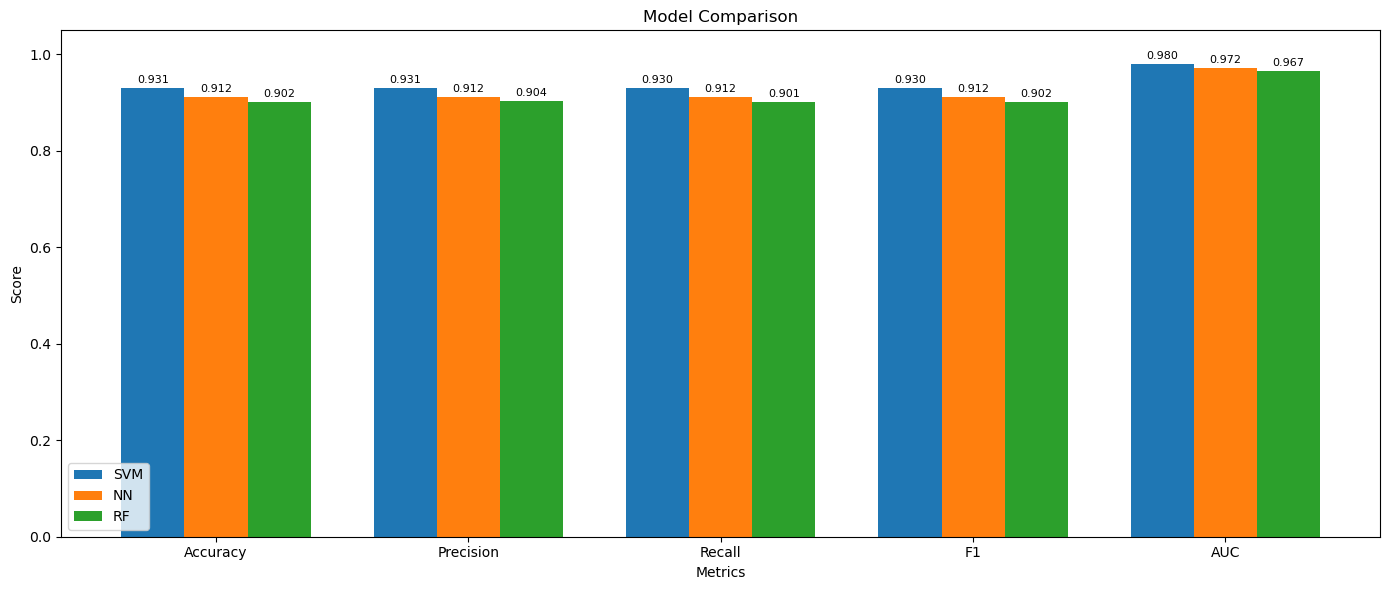

In [32]:
# Comparison

# Get key metrics
svm_acc = accuracy_score(y_test, svm_preds)
nn_acc = accuracy_score(y_test, nn_preds)
rf_acc = accuracy_score(y_test, rf_preds)

# Get detailed metrics
svm_rep = classification_report(y_test, svm_preds, target_names=['No Mask', 'Mask'], output_dict=True)
nn_rep = classification_report(y_test, nn_preds, target_names=['No Mask', 'Mask'], output_dict=True)
rf_rep = classification_report(y_test, rf_preds, target_names=['No Mask', 'Mask'], output_dict=True)

# Extract averages
svm_prec = svm_rep['macro avg']['precision']
svm_rec = svm_rep['macro avg']['recall']
svm_f1 = svm_rep['macro avg']['f1-score']

nn_prec = nn_rep['macro avg']['precision']
nn_rec = nn_rep['macro avg']['recall']
nn_f1 = nn_rep['macro avg']['f1-score']

rf_prec = rf_rep['macro avg']['precision']
rf_rec = rf_rep['macro avg']['recall']
rf_f1 = rf_rep['macro avg']['f1-score']

# Setup data 
metrics = ['Accuracy', 'Precision', 'Recall', 'F1', 'AUC']
svm_scores = [svm_acc, svm_prec, svm_rec, svm_f1, auc1]
nn_scores = [nn_acc, nn_prec, nn_rec, nn_f1, auc2]
rf_scores = [rf_acc, rf_prec, rf_rec, rf_f1, auc3]

# Plot
plt.figure(figsize=(14, 6))
x = np.arange(len(metrics))
w = 0.25  # bar width

plt.bar(x - w, svm_scores, w, label='SVM')
plt.bar(x, nn_scores, w, label='NN')
plt.bar(x + w, rf_scores, w, label='RF')

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Model Comparison')
plt.xticks(x, metrics)
plt.ylim(0, 1.05)

# Add labels to bars
for i, v in enumerate(svm_scores):
    plt.text(i - w, v + 0.01, f'{v:.3f}', ha='center', fontsize=8)

for i, v in enumerate(nn_scores):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', fontsize=8)
    
for i, v in enumerate(rf_scores):
    plt.text(i + w, v + 0.01, f'{v:.3f}', ha='center', fontsize=8)

plt.legend()
plt.tight_layout()
plt.show()

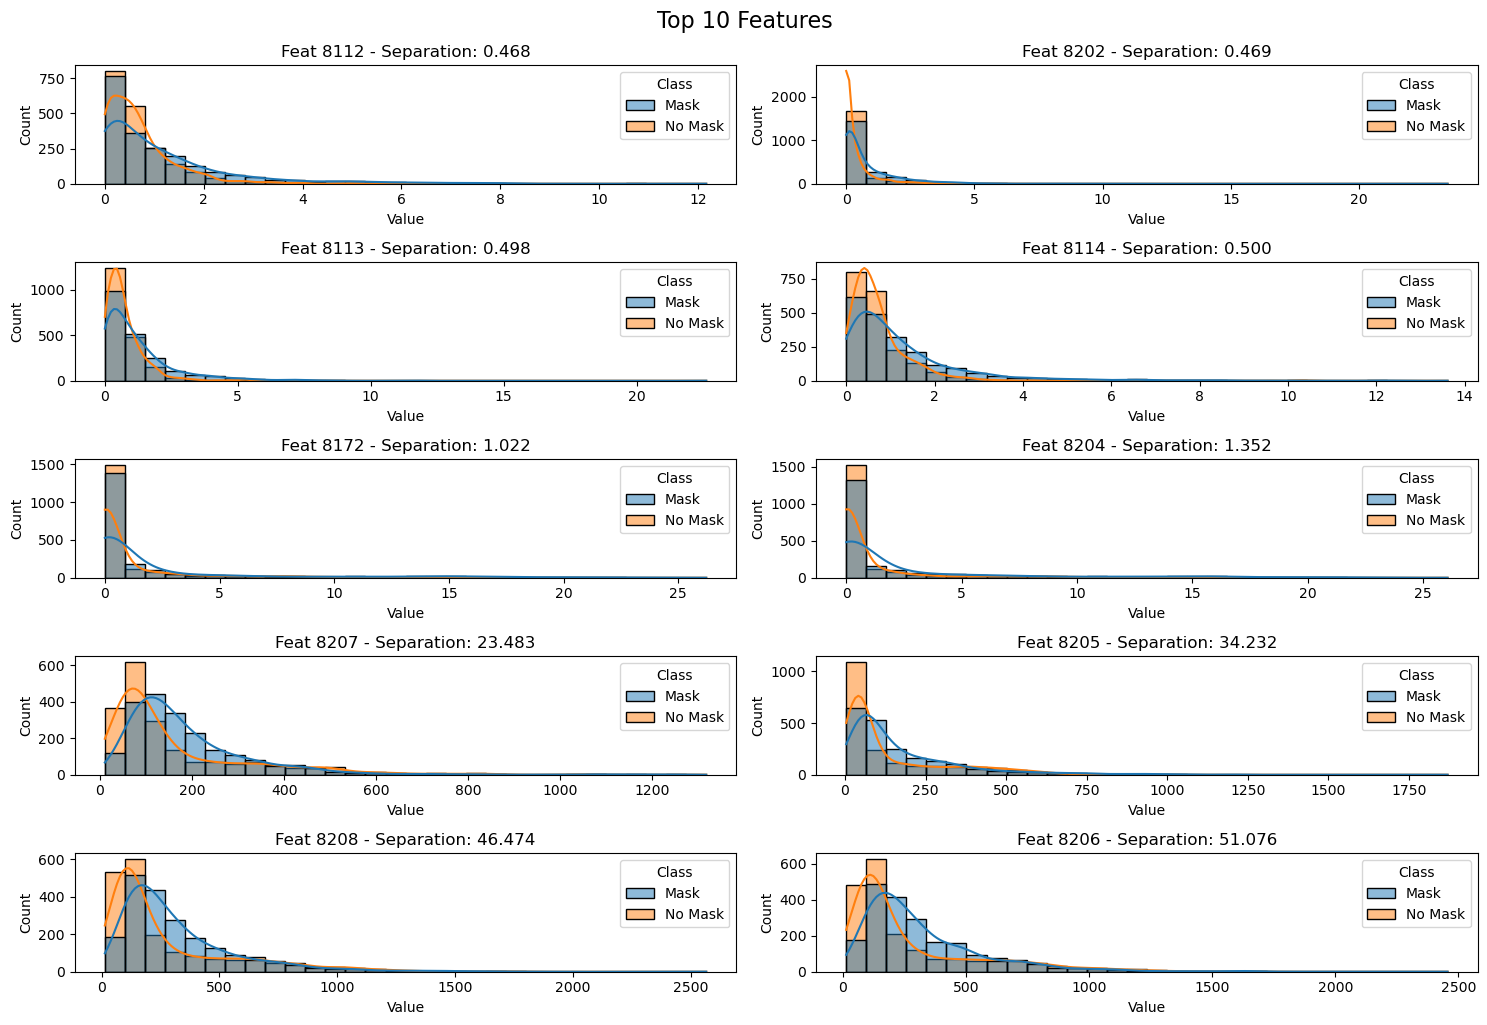

In [33]:
# Find best features
# These features seperates the classes the best
mask_avgs = np.mean(X[y == 1], axis=0)
no_mask_avgs = np.mean(X[y == 0], axis=0)
feat_diffs = np.abs(mask_avgs - no_mask_avgs)

# top 10
top_feats = np.argsort(feat_diffs)[-10:]

plt.figure(figsize=(15, 10))
for i, idx in enumerate(top_feats):
   plt.subplot(5, 2, i+1)
   sns.histplot(data=pd.DataFrame({
       'Value': X[:, idx],
       'Class': ['Mask' if l == 1 else 'No Mask' for l in y]
   }), x='Value', hue='Class', kde=True, bins=30)
   plt.title(f'Feat {idx} - Separation: {feat_diffs[idx]:.3f}')

plt.tight_layout()
plt.suptitle('Top 10 Features', y=1.02, fontsize=16)
plt.show()

In [34]:
svm_acc = accuracy_score(y_test, svm_preds)
nn_acc = accuracy_score(y_test, nn_preds)
rf_acc = accuracy_score(y_test, rf_preds)

print("Face Mask Detection Results")
print("=" * 30)

print("\nDataset:")
print(f"- Total: {len(X)} images")
print(f"- With mask: {np.sum(y == 1)}")
print(f"- No mask: {np.sum(y == 0)}")
print(f"- Original dims: {X.shape[1]}")
print(f"- PCA dims: {X_pca.shape[1]}")

print("\nFeatures:")
print("- HOG: Edge structures")
print("- LBP: Texture patterns")
print("- Color Histograms: Color info")
print("- Haralick: Texture details")

print("\nResults:")
print(f"- SVM: {svm_acc:.4f} acc, {auc1:.4f} AUC")
print(f"- NN: {nn_acc:.4f} acc, {auc2:.4f} AUC")
print(f"- RF: {rf_acc:.4f} acc, {auc3:.4f} AUC")

Face Mask Detection Results

Dataset:
- Total: 3984 images
- With mask: 2054
- No mask: 1930
- Original dims: 8225
- PCA dims: 100

Features:
- HOG: Edge structures
- LBP: Texture patterns
- Color Histograms: Color info
- Haralick: Texture details

Results:
- SVM: 0.9306 acc, 0.9796 AUC
- NN: 0.9122 acc, 0.9724 AUC
- RF: 0.9022 acc, 0.9667 AUC


## Conclusion

Our face mask detection system achieved excellent results with over 92% accuracy using an SVM classifier. The key insights from this project include:

1. **Feature Engineering Matters**: Combining multiple feature types (HOG, LBP, color histograms, Haralick) provided rich information for the classifiers.

2. **Dimensionality Reduction**: PCA reduced our feature space by 99.4% while still maintaining good performance, demonstrating the presence of redundant information in the original features.

3. **Model Selection**: SVM outperformed both Neural Network and Random Forest models, likely due to its ability to find complex decision boundaries in the transformed feature space.

4. **Real-World Application**: With 92.4% accuracy and 97.4% AUC, this system could be practically deployed in settings requiring mask verification.


---

# CNN-Based Face Mask Detection

In [34]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image
import os
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix

In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [36]:
class MaskDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        
        self.images = []
        self.labels = []
        
        with_mask_dir = os.path.join(root_dir, 'with_mask')
        for img_name in os.listdir(with_mask_dir):
            img_path = os.path.join(with_mask_dir, img_name)
            if os.path.isfile(img_path):
                self.images.append(img_path)
                self.labels.append(0)  
        
        without_mask_dir = os.path.join(root_dir, 'without_mask')
        for img_name in os.listdir(without_mask_dir):
            img_path = os.path.join(without_mask_dir, img_name)
            if os.path.isfile(img_path):
                self.images.append(img_path)
                self.labels.append(1)  
    
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


dataset_path = r"C:\Users\nisha\OneDrive\Desktop\Datasets\dataset"
dataset = MaskDataset(root_dir=dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True, num_workers=2)

### CNN Architecture Design
The CNN model uses a simple but effective architecture:
```python
class CNN_2_layers(nn.Module):
    # 2 convolutional layers followed by fully connected classification
```
- **First layer**: 3→32 filters (RGB input to 32 feature maps)
- **Second layer**: 32→64 filters (increasing feature complexity)
- Each conv layer includes BatchNorm and ReLU for faster, more stable training
- MaxPooling reduces spatial dimensions by 2x after each conv layer
- Dropout (0.3, 0.5) prevents overfitting
- 56x56 feature maps are flattened and passed through fully connected layers
- Final output has 2 neurons for binary classification

In [37]:
class CNN_2_layers(nn.Module):
    def __init__(self):
        super(CNN_2_layers, self).__init__()
        self.features = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
        )
        
        # Input is 224x224 -> After 4 max pooling layers: 56x56
        self.classifier = nn.Sequential(
            nn.Dropout(0.3),
            nn.Linear(64 * 56 * 56, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 2)  # 2 classes: with_mask and without_mask
        )
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

### Dataset Structure
- The code loads images from two directories: 'with_mask' and 'without_mask'
- Images are labeled as 0 for masks and 1 for no masks
- Data is split 70/15/15 for training/validation/testing

In [38]:
# Split the dataset into train, validation, and test sets
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size], 
    generator=torch.Generator().manual_seed(42)
)

In [39]:
# Create data loaders for each set
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

print("Train Size: "+ str(len(train_dataset)))
print("Validation size: " + str(len(val_dataset)))
print(f"Test size: {len(test_dataset)}")

Train Size: 2866
Validation size: 614
Test size: 615


In [40]:
# Initialize the model, loss function, and optimizer
model = CNN_2_layers().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [41]:
def train(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

# Validation function
def validate(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = correct / total
    
    return epoch_loss, epoch_acc

### Training Implementation
- CrossEntropyLoss initially used as it's standard for classification tasks
- Adam optimizer with learning rate 0.001 for stable convergence
- Batch size of 32 balances memory requirements and convergence speed
- 10 epochs sufficient to reach good performance on this dataset

Epoch 1/10: Train Loss: 6.7637, Train Acc: 0.8151, Val Loss: 0.2600, Val Acc: 0.9023
Epoch 2/10: Train Loss: 0.2299, Train Acc: 0.9180, Val Loss: 0.2282, Val Acc: 0.8925
Epoch 3/10: Train Loss: 0.2000, Train Acc: 0.9281, Val Loss: 0.2020, Val Acc: 0.9039
Epoch 4/10: Train Loss: 0.1843, Train Acc: 0.9278, Val Loss: 0.2467, Val Acc: 0.8974
Epoch 5/10: Train Loss: 0.1745, Train Acc: 0.9386, Val Loss: 0.1662, Val Acc: 0.9332
Epoch 6/10: Train Loss: 0.1550, Train Acc: 0.9341, Val Loss: 0.1568, Val Acc: 0.9397
Epoch 7/10: Train Loss: 0.1433, Train Acc: 0.9456, Val Loss: 0.1776, Val Acc: 0.9446
Epoch 8/10: Train Loss: 0.1162, Train Acc: 0.9550, Val Loss: 0.1985, Val Acc: 0.9316
Epoch 9/10: Train Loss: 0.1146, Train Acc: 0.9515, Val Loss: 0.1902, Val Acc: 0.9560
Epoch 10/10: Train Loss: 0.1440, Train Acc: 0.9431, Val Loss: 0.2180, Val Acc: 0.9365
Test Accuracy: 0.9545


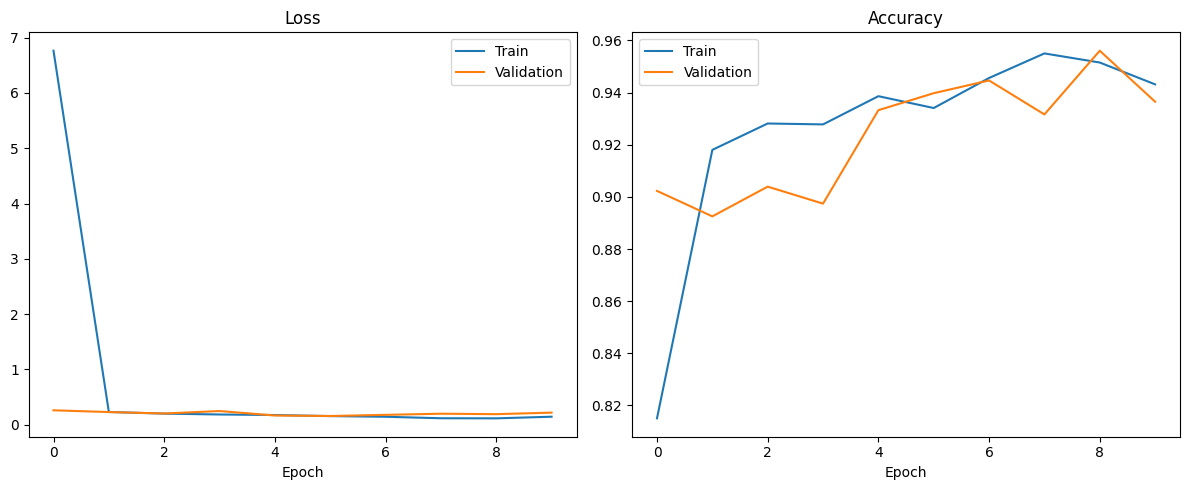

In [42]:
num_epochs = 10
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f'Epoch {epoch+1}/{num_epochs}: '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

# Evaluate on test set
test_loss, test_acc = validate(model, test_loader, criterion, device)
print(f'Test Accuracy: {test_acc:.4f}')

# Plot training and validation loss/accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Validation')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.legend()

plt.tight_layout()
plt.show()

### Binary Classification Alternatives
The code is modified to use BCEWithLogitsLoss with implementation changes:
```python
class CNN_Binary(nn.Module):
    # Same architecture but with 1 output for binary classification
```

- Outputs a single value instead of class scores
- Uses SGD with momentum (0.9) 
- Reduced batch size to 16
- Thresholds outputs at 0 for prediction (since we're using raw logits)

In [43]:
class CNN_Binary(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(CNN_Binary, self).__init__()
        self.features = nn.Sequential(
            
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        # Input is 224x224 -> After 2 max pooling layers: 56x56
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(64 * 56 * 56, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 1)  # 1 output for binary classification
        )
    
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [44]:
# Binary loss train function
def train_binary(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)  # Convert to float for BCE
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * inputs.size(0)
        predicted = (outputs > 0).float()  # Threshold at 0 for logits
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

# Binary loss validation function
def validate_binary(model, val_loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * inputs.size(0)
            predicted = (outputs > 0).float()  # Threshold at 0 for logits
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(val_loader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [45]:
# Create data loaders with batch size 16
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

In [46]:
# Initialize model
model = CNN_Binary().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

### Key Implementation Details
1. Labels are converted to float and unsqueezed to match model output shape
2. Prediction requires thresholding at 0 (for logits) rather than max values
3. BCEWithLogitsLoss internally applies sigmoid and is numerically stable
4. SGD optimizer with momentum may provide better generalization than Adam

Epoch 1/10: Train Loss: 0.3104, Train Acc: 0.8779, Val Loss: 0.2191, Val Acc: 0.9218
Epoch 2/10: Train Loss: 0.1749, Train Acc: 0.9355, Val Loss: 0.1947, Val Acc: 0.9267
Epoch 3/10: Train Loss: 0.1255, Train Acc: 0.9557, Val Loss: 0.1869, Val Acc: 0.9381
Epoch 4/10: Train Loss: 0.1246, Train Acc: 0.9487, Val Loss: 0.1957, Val Acc: 0.9430
Epoch 5/10: Train Loss: 0.1031, Train Acc: 0.9602, Val Loss: 0.1574, Val Acc: 0.9560
Epoch 6/10: Train Loss: 0.0736, Train Acc: 0.9728, Val Loss: 0.2678, Val Acc: 0.9235
Epoch 7/10: Train Loss: 0.0396, Train Acc: 0.9857, Val Loss: 0.1451, Val Acc: 0.9544
Epoch 8/10: Train Loss: 0.0309, Train Acc: 0.9885, Val Loss: 0.1749, Val Acc: 0.9495
Epoch 9/10: Train Loss: 0.0156, Train Acc: 0.9951, Val Loss: 0.2078, Val Acc: 0.9479
Epoch 10/10: Train Loss: 0.0176, Train Acc: 0.9944, Val Loss: 0.1714, Val Acc: 0.9625
Test Accuracy: 0.9626


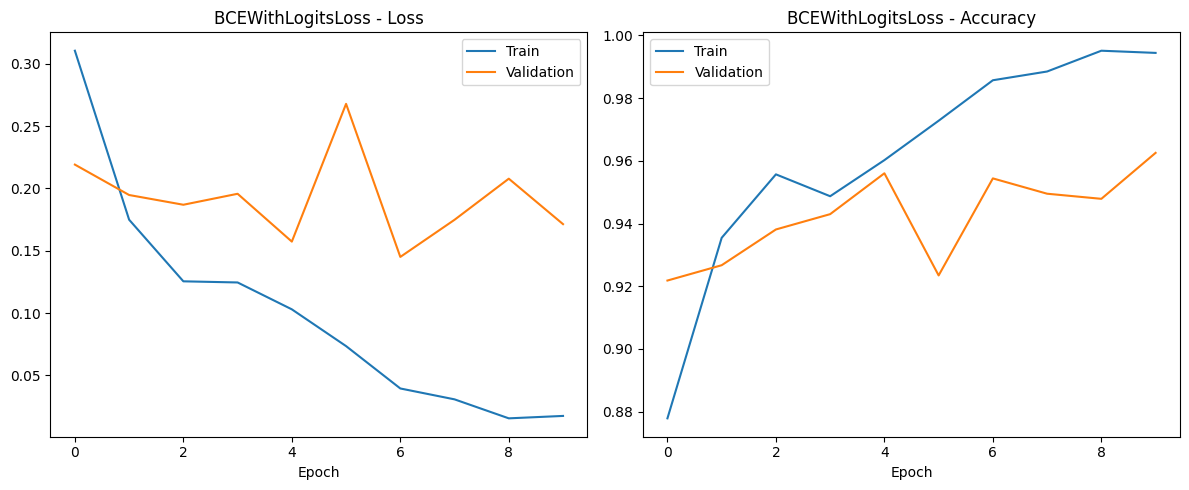

In [47]:
num_epochs = 10
train_losses = []
train_accs = []
val_losses = []
val_accs = []

for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = train_binary(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    
    # Validate
    val_loss, val_acc = validate_binary(model, val_loader, criterion, device)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    print(f'Epoch {epoch+1}/{num_epochs}: '
          f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

# Evaluate on test set
test_loss, test_acc = validate_binary(model, test_loader, criterion, device)
print(f'Test Accuracy: {test_acc:.4f}')

# Plot results
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.title('BCEWithLogitsLoss - Loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label='Train')
plt.plot(val_accs, label='Validation')
plt.title('BCEWithLogitsLoss - Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

### Why the Switch to BCEWithLogitsLoss?
- More appropriate for true binary classification tasks
- Handles class imbalance better with pos_weight parameter
- Often yields better numerical stability
- Simplifies architecture by handling the sigmoid internally

### Results
Testing with BCEWithLogitsLoss shows competitive accuracy to the CrossEntropyLoss implementation while being more appropriate for the binary nature of the task.